# Scicite pre-process

In [1]:
import pandas as pd
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import *

/home/davialvb/.pyenv/versions/3.12.2/envs/master_degree/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/davialvb/.pyenv/versions/3.12.2/envs/master_degree/lib/python3.12/site-packages/transformers/deepspeed.py:24: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
No CUDA runtime is found, using CUDA_HOME='/opt/cuda:/opt/cuda'


In [2]:
from sklearn.model_selection import train_test_split

In [3]:
import sys
parent_directory = os.path.abspath('..')
sys.path.append(parent_directory)

In [4]:
from utils.common import alloc_map, map_title_section, normalize_title_section, count_words

In [28]:
## 3c from (https://www.kaggle.com/c/3c-shared-task-purpose-v2/overview) 
train_path_threec = '../data/3c/SDP_train.csv'
test_path_threec = '../data/3c/SDP_test.csv'

In [29]:
df_train = pd.read_csv(train_path_threec)
df_unlabeled = pd.read_csv(test_path_threec)

In [30]:
df_train.shape, df_unlabeled.shape

((3000, 8), (1000, 7))

In [31]:
df_train.head()

,unique_id,core_id,citing_title,citing_author,cited_title,cited_author,citation_context,citation_class_label
0,CC1,158977742,Ontology-Based Recommendation of Editorial Pro...,Thiviyan Thanapalasingam,Web search personalization with ontological us...,Sieg,They usually generate user models that describ...,5
1,CC2,158977742,Ontology-Based Recommendation of Editorial Pro...,Thiviyan Thanapalasingam,Exploring Scholarly Data with Rexplore,Osborne,The Computer Science Ontology (CSO)[3]is a lar...,0
2,CC3,158977742,Ontology-Based Recommendation of Editorial Pro...,Thiviyan Thanapalasingam,Klink-2: Integrating Multiple Web Sources to G...,Osborne,"In order to do so, we characterized all SN pub...",0
3,CC4,158977742,Ontology-Based Recommendation of Editorial Pro...,Thiviyan Thanapalasingam,Forecasting the Spreading of Technologies in R...,Osborne,"This API supports a number of applications, in...",0
4,CC5,158977742,Ontology-Based Recommendation of Editorial Pro...,Thiviyan Thanapalasingam,Supporting Springer Nature Editors by means of...,Osborne,It works according to three main steps:1) It r...,5


In [7]:
citation_label = {
    0: "background",
    1: "compare_contrast",
    2: "extension",
    3: "future",
    4: "motivation",
    5: "uses"
}

In [8]:
df_train['citation_class_label'] = df_train['citation_class_label'].map(citation_label)

In [9]:
df_train = df_train[['citation_context','citing_title','cited_title', 'citation_class_label']]
df_unlabeled = df_unlabeled[['unique_id', 'citation_context','citing_title', 'cited_title']]

df_train.columns = ['text', 'citing_title', 'cited_title', 'intent']
df_unlabeled.columns = ['unique_id', 'text', 'citing_title', 'cited_title']

In [10]:
df_train, df_test = train_test_split(df_train, test_size=1000, random_state=42)

In [11]:
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42)

In [12]:
df_train.shape

(2000, 4)

In [26]:
df_val.shape

(500, 4)

In [13]:
df_test.shape

(500, 4)

In [14]:
df_train.intent.value_counts(normalize=True)

intent
background          0.5440
uses                0.1550
compare_contrast    0.1295
motivation          0.0920
extension           0.0590
future              0.0205
Name: proportion, dtype: float64

In [15]:
df_test.intent.value_counts()

intent
background          274
uses                 79
compare_contrast     58
motivation           49
extension            28
future               12
Name: count, dtype: int64

In [16]:
df_val.intent.value_counts()

intent
background          286
uses                 86
compare_contrast     51
motivation           43
extension            25
future                9
Name: count, dtype: int64

In [17]:
df_dev = df_unlabeled.copy()

In [18]:
df_train['text'] = df_train.text.str.lower()
df_train['cited_title'] = df_train.cited_title.str.lower()
df_train['citing_title'] = df_train.citing_title.str.lower()

df_dev['text'] = df_dev.text.str.lower()
df_dev['cited_title'] = df_dev.cited_title.str.lower()
df_dev['citing_title'] = df_dev.citing_title.str.lower()

df_test['text'] = df_test.text.str.lower()
df_test['cited_title'] = df_test.cited_title.str.lower()
df_test['citing_title'] = df_test.citing_title.str.lower()

df_val['text'] = df_val.text.str.lower()
df_val['cited_title'] = df_val.cited_title.str.lower()
df_val['citing_title'] = df_val.citing_title.str.lower()

In [31]:
df_train.to_csv('../data/3c/labeled_3c.csv', index=False)
df_dev.to_csv('../data/3c/final_test_3c.csv', index=False)
df_test.to_csv('../data/3c/unlabeled_3c.csv', index=False)
df_val.to_csv('../data/3c/test_3c.csv', index=False)

In [19]:
all_threec = pd.concat([df_train, df_unlabeled])

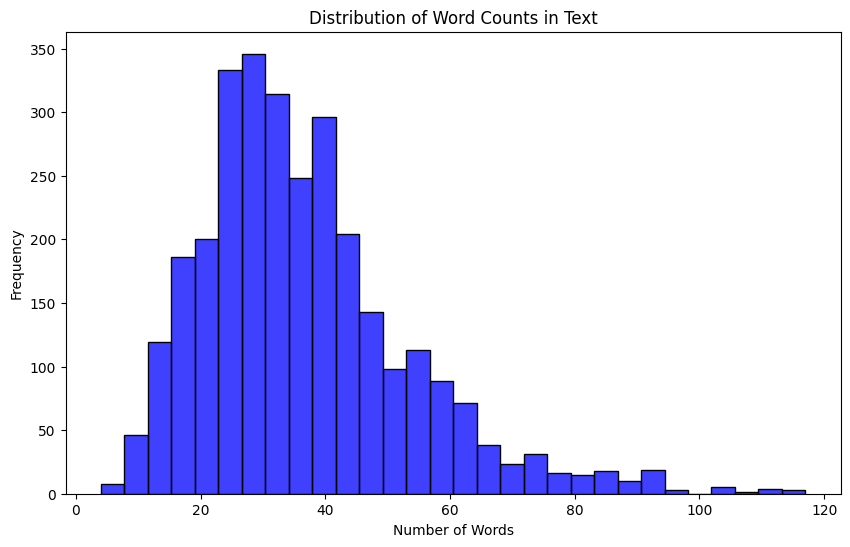

In [20]:
all_threec['word_count'] = all_threec['text'].apply(count_words)

plt.figure(figsize=(10, 6))
sns.histplot(all_threec['word_count'], bins=30, kde=False, color='blue')

plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts in Text')

plt.show()

In [21]:
tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /home/davialvb/.cache/huggingface/hub/models--allenai--scibert_scivocab_uncased/snapshots/24f92d32b1bfb0bcaf9ab193ff3ad01e87732fc1/config.json
Model config BertConfig {
  "_name_or_path": "allenai/scibert_scivocab_uncased",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31090
}

loading file vocab.txt from cache at /home/davialvb/.cache/huggingface/hub/models--allenai--scibert_scivocab_uncased/s

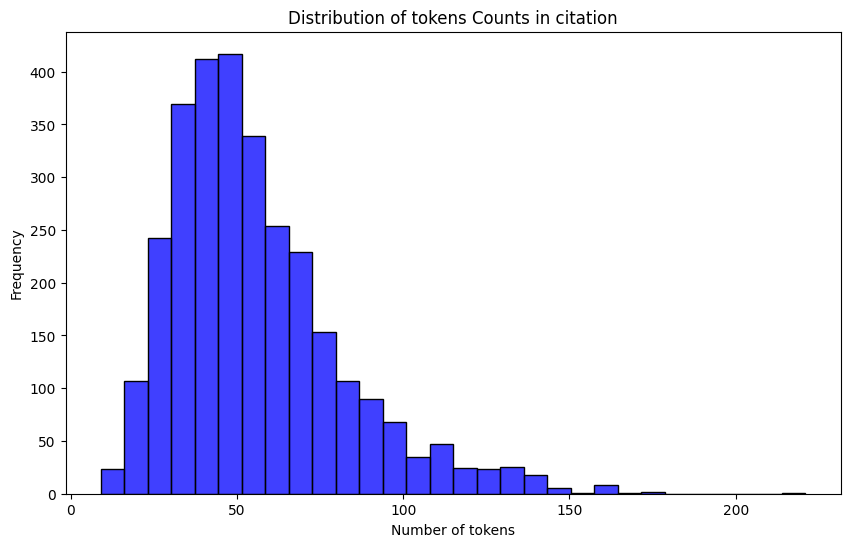

In [22]:
all_threec['bert_token_cont'] = all_threec['text'].apply(lambda x: len(tokenizer.encode_plus(x).get('input_ids')))

plt.figure(figsize=(10, 6))
sns.histplot(all_threec['bert_token_cont'], bins=30, kde=False, color='blue')

plt.xlabel('Number of tokens')
plt.ylabel('Frequency')
plt.title('Distribution of tokens Counts in citation')

plt.show()

In [35]:
all_threec.word_count.describe()

count    3000.000000
mean       36.492333
std        16.717150
min         4.000000
25%        25.000000
50%        34.000000
75%        44.000000
max       117.000000
Name: word_count, dtype: float64

In [23]:
all_threec.bert_token_cont.describe()

count    3000.000000
mean       55.696667
std        25.732833
min         9.000000
25%        38.000000
50%        50.000000
75%        68.000000
max       221.000000
Name: bert_token_cont, dtype: float64

In [36]:
df_train.shape, df_test.shape

((2000, 4), (500, 4))

In [122]:
df_train.to_csv('../data/acl_gan_bert/labeled_scicite.csv', index=False)
df_dev.to_csv('../data/acl_gan_bert/unlabeled_scicite.csv', index=False)
df_test.to_csv('../data/acl_gan_bert/test_scicite.csv', index=False)

In [123]:
df_train.to_csv('../../acl_gan_bert/labeled_scicite.csv', index=False)
df_dev.to_csv('../../acl_gan_bert/unlabeled_scicite.csv', index=False)
df_test.to_csv('../../acl_gan_bert/test_scicite.csv', index=False)